In [1]:
# set up the python
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import cartopy.feature as cft
import cftime
import IPython.display
import sys, os, warnings

In [2]:
session = cc.database.create_session()

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/34215/status,
Dashboard: /proxy/34215/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41825,Workers: 4
Dashboard: /proxy/34215/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:39519,Total threads: 2
Dashboard: /proxy/43463/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:42931,


In [4]:
# time period
start_time = '1995-01-01'
end_time = '2000-01-01'

In [5]:
# load MOM6 hmo(x,y,rho,t)
hmo = cc.querying.getvar('panant-01-hycom1','hmo',session,start_time=start_time, end_time=end_time)
# load MOM6 umo()
umo = cc.querying.getvar('panant-01-hycom1','umo',session,start_time=start_time, end_time=end_time)

In [6]:
# load ACCESS-OM2 dzt
# 01
dz01 = cc.querying.getvar(expt='01deg_jra55v13_iaf', variable='dzt', 
                          session=session, frequency='1 monthly',
                          start_time='1984-12-31 00:00:00', 
                          end_time='2017-11-30 00:00:00').sel(yt_ocean = slice(-90,-40)).sel(time=slice(start_time,end_time)).mean('time')
# 025
dz25 = cc.querying.getvar(expt='025deg_jra55_iaf_omip2_cycle1', variable='dht', 
                          session=session, frequency='1 monthly',
                          start_time='1957-12-31 00:00:00', 
                          end_time='2018-11-30 00:00:00').sel(yt_ocean = slice(-90,-40)).sel(time=slice(start_time,end_time)).mean('time')
# 1deg
dz = cc.querying.getvar(expt='1deg_jra55_iaf_omip2_cycle1', variable='dht', 
                          session=session, frequency='1 monthly',
                          start_time='1957-12-31 00:00:00', 
                          end_time='2018-11-30 00:00:00').sel(yt_ocean = slice(-90,-40)).sel(time=slice(start_time,end_time)).mean('time')

In [7]:
# load ACCESS-OM2 transx_rho
# 01deg
trans01 = cc.querying.getvar(expt='01deg_jra55v13_iaf', variable='tx_trans_rho', 
                          session=session, frequency='1 monthly',
                          start_time='1984-12-31 00:00:00', 
                          end_time='2017-11-30 00:00:00').sel(grid_yt_ocean = slice(-90,-50)).sel(time=slice(start_time,end_time)).mean('time')
# 025deg
trans025 = cc.querying.getvar(expt='025deg_jra55_iaf_omip2_cycle1', variable='tx_trans_rho', 
                          session=session, frequency='1 monthly',
                          start_time='1957-12-31 00:00:00', 
                          end_time='2018-11-30 00:00:00').sel(grid_yt_ocean = slice(-90,-50)).sel(time=slice(start_time,end_time)).mean('time')
# 1deg
trans1 = cc.querying.getvar(expt='1deg_jra55_iaf_omip2_cycle1', variable='tx_trans_rho', 
                          session=session, frequency='1 monthly',
                          start_time='1957-12-31 00:00:00', 
                          end_time='2018-11-30 00:00:00').sel(grid_yt_ocean = slice(-90,-50)).sel(time=slice(start_time,end_time)).mean('time')

distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


In [8]:
# calculate the bathymetry
hmo1 = hmo.sel(time=slice(start_time,end_time)).mean('time').sum('rho2_l').load()
depth01 = dz01.sum('st_ocean').load()
depth025 = dz25.sum('st_ocean').load()
depth1 = dz.sum('st_ocean').load()


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


In [10]:
# calculate zonal transport Sv
fluxm = (umo.sel(time=slice(start_time,end_time)).mean('time').sel(yh = slice(-90,-50)).cumsum('yh').sum('rho2_l')/1e9).load()
flux01 = (trans01.cumsum('grid_yt_ocean').sum('potrho')/1e9).load()
flux025 = (trans025.cumsum('grid_yt_ocean').sum('potrho')/1e9).load()
flux1 = (trans1.cumsum('grid_yt_ocean').sum('potrho')/1e9).load()

Text(0, 0.5, 'Streamfunction (Sv)')

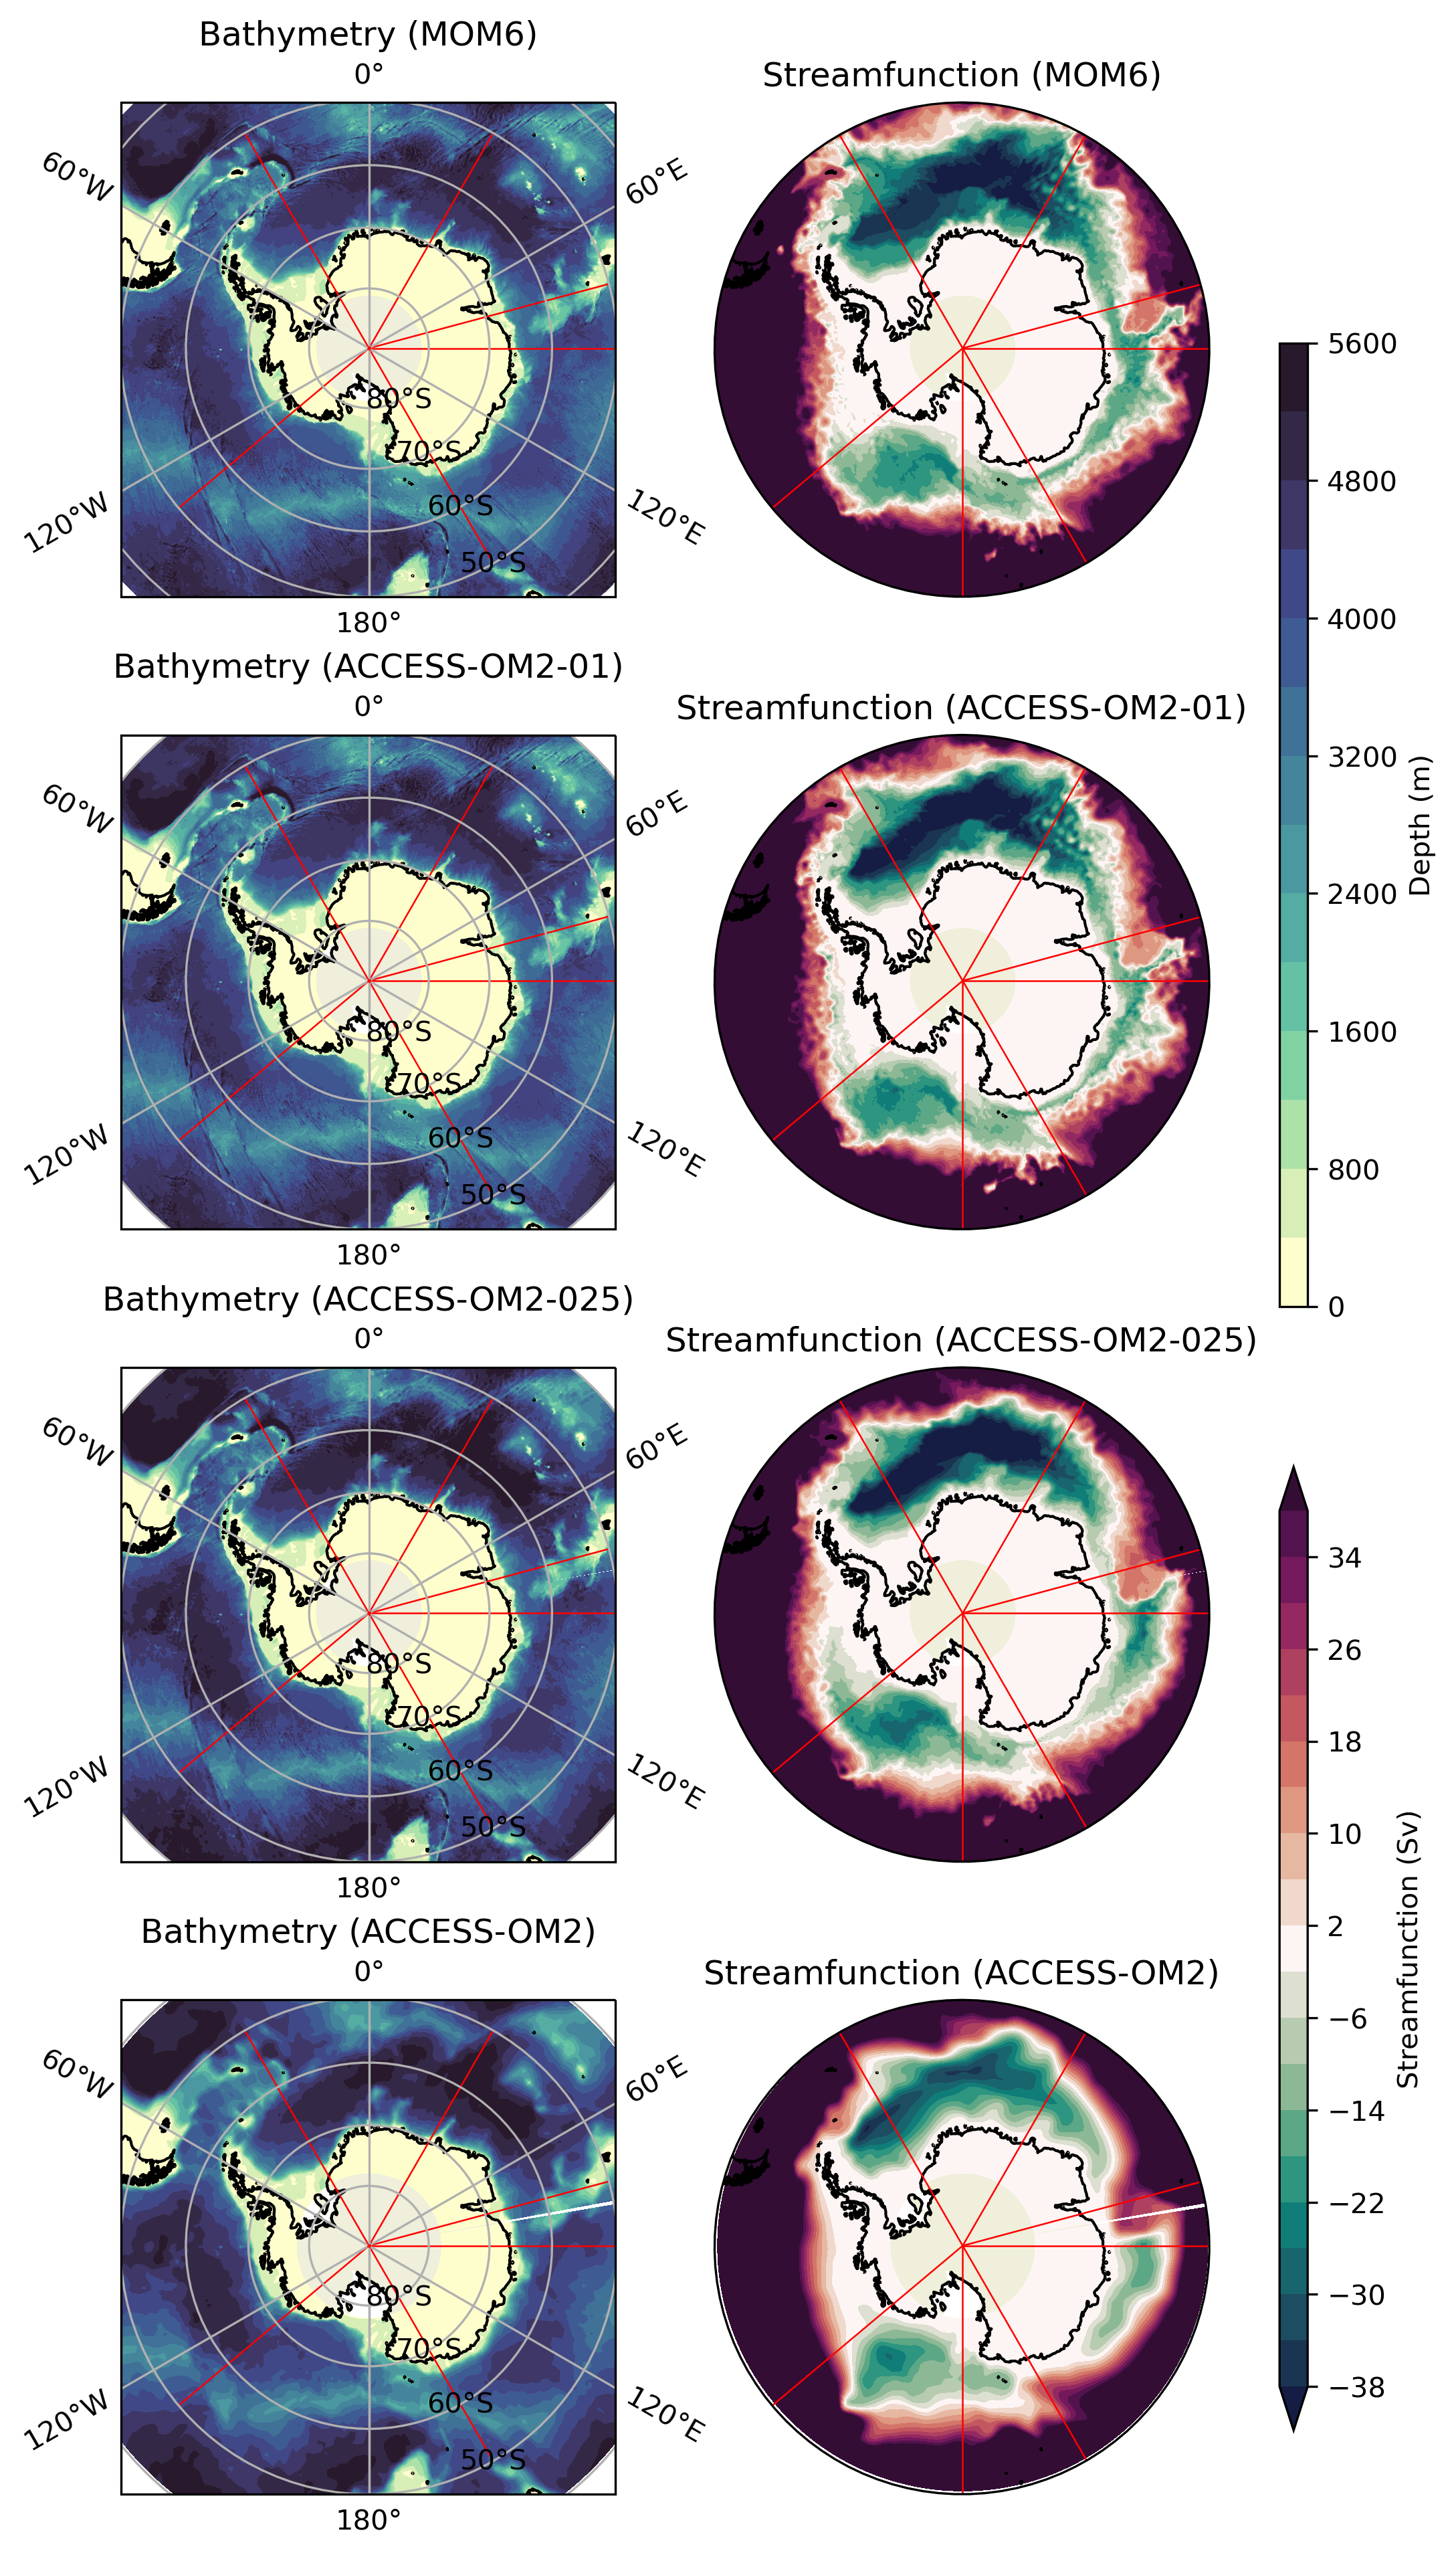

In [19]:
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(7, 16), dpi=300)
# MOM6
# plot the bathymetry
ax = plt.subplot(4,2,1,projection = projection)
ax.gridlines(draw_labels=True)
p1 = hmo1.plot.contourf(ax=ax, levels = np.arange(0,6000,400),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.deep,add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.plot([-30,-30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([30,30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([75,75],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-270,-270],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-210,-210],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-180,-180],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-130,-130],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.set_title('Bathymetry (MOM6)')

# plot the streamfunction
ax = plt.subplot(4,2,2,projection = projection)

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p2 = fluxm.plot.contourf(ax=ax, levels = np.arange(-38,40,4),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl,add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

ax.plot([-30,-30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([30,30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([75,75],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-270,-270],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-210,-210],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-180,-180],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-130,-130],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.set_title('Streamfunction (MOM6)')

# ACCESS-OM2-01
# plot the bathymetry
ax = plt.subplot(4,2,3,projection = projection)
ax.gridlines(draw_labels=True)
p1 = depth01.plot.contourf(ax=ax, levels = np.arange(0,6000,400),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.deep,add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.plot([-30,-30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([30,30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([75,75],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-270,-270],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-210,-210],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-180,-180],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-130,-130],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.set_title('Bathymetry (ACCESS-OM2-01)')

# plot the streamfunction
ax = plt.subplot(4,2,4,projection = projection)

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p2 = flux01.plot.contourf(ax=ax, levels = np.arange(-38,40,4),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl,add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

ax.plot([-30,-30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([30,30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([75,75],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-270,-270],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-210,-210],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-180,-180],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-130,-130],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.set_title('Streamfunction (ACCESS-OM2-01)')

# ACCESS-OM2-025
# plot the bathymetry
ax = plt.subplot(4,2,5,projection = projection)
ax.gridlines(draw_labels=True)
p1 = depth025.plot.contourf(ax=ax, levels = np.arange(0,6000,400),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.deep,add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.plot([-30,-30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([30,30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([75,75],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-270,-270],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-210,-210],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-180,-180],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-130,-130],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.set_title('Bathymetry (ACCESS-OM2-025)')

# plot the streamfunction
ax = plt.subplot(4,2,6,projection = projection)

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p2 = flux025.plot.contourf(ax=ax, levels = np.arange(-38,40,4),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl,add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

ax.plot([-30,-30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([30,30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([75,75],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-270,-270],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-210,-210],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-180,-180],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-130,-130],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.set_title('Streamfunction (ACCESS-OM2-025)')

# ACCESS-OM2
# plot the bathymetry
ax = plt.subplot(4,2,7,projection = projection)
ax.gridlines(draw_labels=True)
p1 = depth1.plot.contourf(ax=ax, levels = np.arange(0,6000,400),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.deep,add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())
ax.plot([-30,-30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([30,30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([75,75],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-270,-270],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-210,-210],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-180,-180],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-130,-130],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.set_title('Bathymetry (ACCESS-OM2)')

# plot the streamfunction
ax = plt.subplot(4,2,8,projection = projection)

theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
theta = np.linspace(0,2*np.pi,100)
center,radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p2 = flux1.plot.contourf(ax=ax, levels = np.arange(-38,40,4),transform=ccrs.PlateCarree(),
                              cmap=cm.cm.curl,add_colorbar = False)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280,80,-82,-50], crs = ccrs.PlateCarree())

ax.plot([-30,-30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([30,30],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([75,75],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-270,-270],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-210,-210],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-180,-180],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.plot([-130,-130],[-90,-50],color='r',transform=ccrs.PlateCarree(),linewidth = 0.6)
ax.set_title('Streamfunction (ACCESS-OM2)')
# add the colorbar
ax = plt.axes([0.95, 0.5, 0.02, 0.3])
cb = plt.colorbar(p1, cax=ax, orientation='vertical',extend='neither')
cb.ax.set_ylabel('Depth (m)')

ax = plt.axes([0.95, 0.15, 0.02, 0.3])
cb = plt.colorbar(p2, cax=ax, orientation='vertical',extend='both')
cb.ax.set_ylabel('Streamfunction (Sv)')